In [1]:
### Identify subclusters of already existing annotations

# Load Libraries

## External Libraries

In [2]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import scanorama
import os
import multiprocessing
import random
import time
#import git
import sys
from datetime import date
from matplotlib.backends.backend_pdf import PdfPages

## Own functions

In [3]:
import MS1_Clustering

In [4]:
from MS1_Clustering import *

# Load Data

## Configurations

### Technical configurations

In [7]:
multiprocessing.cpu_count()  ### total amount of cpu on the used core

24

In [8]:
len(os.sched_getaffinity(0)) ### amount of available cpus

8

In [9]:
sc.settings.n_jobs   # default number of CPUs to use for parallel computing

1

In [10]:
sc.settings.max_memory  # maximum memory to use in GB

15

In [11]:
random.seed(7)

In [12]:
ncore = '24'

In [13]:
random_state_var = 7

In [14]:
n_jobs_var = 24

In [15]:
os.environ["OMP_NUM_THREADS"] = ncore
os.environ["OPENBLAS_NUM_THREADS"] = ncore
os.environ["MKL_NUM_THREADS"] = ncore
os.environ["VECLIB_MAXIMUM_THREADS"] = ncore
os.environ["NUMEXPR_NUM_THREADS"] = ncore

In [16]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 0

-----
anndata     0.8.0
scanpy      1.9.3
-----
Cython              3.0.2
MS1_Clustering      NA
PIL                 9.4.0
anyio               NA
attr                21.2.0
babel               2.9.1
backcall            0.2.0
brotli              NA
certifi             2023.07.22
cffi                1.14.6
chardet             4.0.0
charset_normalizer  2.0.0
cycler              0.10.0
cython              3.0.2
cython_runtime      NA
dateutil            2.8.2
decorator           5.0.9
defusedxml          0.7.1
entrypoints         0.3
fontTools           4.39.2
h5py                3.8.0
idna                3.1
igraph              0.9.9
importlib_resources NA
ipykernel           6.1.0
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              3.0.1
joblib              1.2.0
json5               NA
jsonschema          3.2.0
jupyter_server      1.10.2
jupyterlab_server   2.7.0
kiwisolver          1.4.4
leidenalg           0.8.9
llvmlite            0.39.1
louvain             0.8.1


### Parameters

In [17]:
data_path = '../data/current'

In [19]:
variant = 'V1_Scanorama_Singlets'

In [20]:
variants = [variant]

In [21]:
result_path = '../results/current'

In [22]:
### Dataset storing annotations

In [23]:
#saved_annotations = pd.read_csv(result_path + '/B-Analysis/saved_annotations.csv')

In [24]:
save_path = '_B5_' + variant + '_Annotations.pdf'

## Meta-Data File

In [25]:
library_hashtag_mapping = pd.read_csv(data_path + "preprocessed-data/meta-data/Mapping_Hashtag_Sample.csv") 

In [26]:
#library_hashtag_mapping

## Scanorama Dataset

In [27]:
dataset_path = data_path + '/analysis/B/B2_Integrated_Scanorama_Singlet_annotated_rna.h5ad'

In [28]:
adata_scanorama = sc.read_h5ad(dataset_path)

In [29]:
anndata_dict_scanorama = dict.fromkeys(variants)

In [30]:
anndata_dict_scanorama['V1_Scanorama_Singlets']  = adata_scanorama

# Data preparations & Inspection

## Inspection

In [31]:
## scanorama data

In [32]:
adata_scanorama

AnnData object with n_obs × n_vars = 148275 × 2000
    obs: 'nCount_HTO', 'nFeature_HTO', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'HTO_classification_final', 'name', 'library', 'id', 'read', 'pattern', 'sequence', 'feature_type', 'Unnamed: 7', 'in_sample', 'display_name', 'group', 'HTO_Doublet_Classification', 'doublet_score', 'predicted_doublet', 'A5_scrublet_predicted_doublet_lib0.1', 'A5_scrublet_doublet_score_lib_0.1', 'A5_scrublet_predicted_doublet_lib0.2', 'A5_scrublet_doublet_score_lib_0.2', 'A5_scrublet_predicted_doublet_lib', 'A5_scrublet_doublet_score_lib', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'valid_cell_filter_dying', 'valid_cell_filter_doublet', 'A7_PCA_50_10_neighbors_cluster', 'A7_PCA_100_10_neighbors_cluster', 'A7_PCA_100_50_neighbors_cluster', 'A7_PCA_500_50_neighbors_cluster', 'A7_Singlet_PCA_50_10_neighbors_cluste

In [33]:
adata_scanorama.X.sum(axis=1) # scanorama corrected X

matrix([[21.065617],
        [25.584118],
        [21.224699],
        ...,
        [22.754984],
        [29.788113],
        [23.377083]], dtype=float32)

In [34]:
# sc.pp.highly_variable_genes(adata_scanorama, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [35]:
#adata_scanorama[:,adata_scanorama.var['highly_variable']==True] # would only yield 101 highly variable genes

## Preparation

### Remove ribosomal and mitochondrial genes

In [36]:
#anndata_dict_singlet_rb_mt

In [103]:
for key in anndata_dict_scanorama:
    print(key)
    ### Concatenated object
    anndata_dict_scanorama[key] = anndata_dict_scanorama[key][anndata_dict_scanorama[key].obs['HTO_classification.global']=='Singlet']
    anndata_dict_scanorama[key] = anndata_dict_scanorama[key][:,np.logical_and(anndata_dict_scanorama[key].var['rb'] == False , anndata_dict_scanorama[key].var['mt'] == False)]

V1_Scanorama_Singlets


In [104]:
anndata_dict_scanorama[key]  # 1905 genes left

View of AnnData object with n_obs × n_vars = 148275 × 2000
    obs: 'nCount_HTO', 'nFeature_HTO', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'HTO_classification_final', 'name', 'library', 'id', 'read', 'pattern', 'sequence', 'feature_type', 'Unnamed: 7', 'in_sample', 'display_name', 'group', 'HTO_Doublet_Classification', 'doublet_score', 'predicted_doublet', 'A5_scrublet_predicted_doublet_lib0.1', 'A5_scrublet_doublet_score_lib_0.1', 'A5_scrublet_predicted_doublet_lib0.2', 'A5_scrublet_doublet_score_lib_0.2', 'A5_scrublet_predicted_doublet_lib', 'A5_scrublet_doublet_score_lib', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'valid_cell_filter_dying', 'valid_cell_filter_doublet', 'A7_PCA_50_10_neighbors_cluster', 'A7_PCA_100_10_neighbors_cluster', 'A7_PCA_100_50_neighbors_cluster', 'A7_PCA_500_50_neighbors_cluster', 'A7_Singlet_PCA_50_10_neighbor

In [105]:
#anndata_dict_singlet_rb_mt[key]  # 1392 genes left

In [106]:
#sum(anndata_dict[key].var['rb'])

In [107]:
#sum(anndata_dict[key].var['mt'])

### Filter on cell-type

In [108]:
anndata_dict_scanorama[key].obs

nCount_HTO  nFeature_HTO  nCount_RNA  nFeature_RNA  \
AAACCCACATACAGGG-1-L1       1574.0             7      3947.0          1232   
AAACCCACATGACTTG-1-L1        379.0             7      5871.0          1890   
AAACCCAGTCATCAGT-1-L1        421.0             7      3889.0          1297   
AAACCCAGTGGTAATA-1-L1        478.0             7      5094.0          1327   
AAACCCATCATCACAG-1-L1        851.0             7     17480.0          2363   
...                            ...           ...         ...           ...   
TTTGTTGCAGGTTCGC-1-L14      1666.0             9      8451.0          2433   
TTTGTTGGTACCTAGT-1-L14       810.0             9      7125.0          1743   
TTTGTTGGTACGTTCA-1-L14       883.0             9      4079.0          1412   
TTTGTTGGTGGACCAA-1-L14      1159.0             9     17625.0          4068   
TTTGTTGTCGAAGAAT-1-L14       767.0             9      3232.0          1241   

                        percent_mt HTO_maxID HTO_secondID  HTO_margin  \
AAACCCACATACAGGG-1-L1     7.980745       9.1          1.1    2.253048   
AAACCCACATGACTTG-1-L1     7.256004       9.1          7.1    0.943193   
AAACCCAGTCATCAGT-1-L1     4.551299       7.1          1.1    2.265289   
AAACCCAGTGGTAATA-1-L1     6.340793       9.1          8.1    1.319735   
AAACCCATCATCACAG-1-L1     2.665904       9.1          5.1    1.629594   
...                            ...       ...          ...         ...   
TTTGTTGCAGGTTCGC-1-L14    5.324814      26.4         23.4    2.155460   
TTTGTTGGTACCTAGT-1-L14    4.505263      22.4         23.4    0.582970   
TTTGTTGGTACGTTCA-1-L14    7.697965      23.4         20.4    1.062823   
TTTGTTGGTGGACCAA-1-L14    3.290780      28.4         24.4    2.327270   
TTTGTTGTCGAAGAAT-1-L14   10.550743      23.4         21.4    0.554467   

                       HTO_classification HTO_classification.global  ...  \
AAACCCACATACAGGG-1-L1                 9.1                   Singlet  ...   
AAACCCACATGACTTG-1-L1                 9.1                   Singlet  ...   
AAACCCAGTCATCAGT-1-L1                 7.1                   Singlet  ...   
AAACCCAGTGGTAATA-1-L1                 9.1                   Singlet  ...   
AAACCCATCATCACAG-1-L1                 9.1                   Singlet  ...   
...                                   ...                       ...  ...   
TTTGTTGCAGGTTCGC-1-L14               26.4                   Singlet  ...   
TTTGTTGGTACCTAGT-1-L14               22.4                   Singlet  ...   
TTTGTTGGTACGTTCA-1-L14               23.4                   Singlet  ...   
TTTGTTGGTGGACCAA-1-L14               28.4                   Singlet  ...   
TTTGTTGTCGAAGAAT-1-L14               23.4                   Singlet  ...   

                        A7_Singlet_PCA_50_10_neighbors_cluster  \
AAACCCACATACAGGG-1-L1                                       10   
AAACCCACATGACTTG-1-L1                                       11   
AAACCCAGTCATCAGT-1-L1                                        0   
AAACCCAGTGGTAATA-1-L1                                        1   
AAACCCATCATCACAG-1-L1                                       19   
...                                                        ...   
TTTGTTGCAGGTTCGC-1-L14                                       4   
TTTGTTGGTACCTAGT-1-L14                                       0   
TTTGTTGGTACGTTCA-1-L14                                       7   
TTTGTTGGTGGACCAA-1-L14                                       6   
TTTGTTGTCGAAGAAT-1-L14                                       3   

                       A7_Singlet_PCA_100_10_neighbors_cluster  \
AAACCCACATACAGGG-1-L1                                        7   
AAACCCACATGACTTG-1-L1                                        8   
AAACCCAGTCATCAGT-1-L1                                        0   
AAACCCAGTGGTAATA-1-L1                                        1   
AAACCCATCATCACAG-1-L1                                       16   
...                                                        ...   
TTTGTTGCAGGTTCGC-1-L14                    

In [109]:
pd.unique(anndata_dict_scanorama[key].obs['cell_type']).astype('string')

<StringArray>
[                 'B-cell', 'Monocytes - CD16_FCGR3A',
              'T-cell-CD4',            'Plasma Blast',
              'T-cell-CD8',        'Monocytes - CD14',
                   'Other',                      'NK',
               'Dendritic',              'Progenitor',
          'Megakaryocytes']
Length: 11, dtype: string

In [110]:
cell_type = ['T-cell-CD4']

In [111]:
#### Filter on celll-type

In [112]:
for key in anndata_dict_scanorama:
    print(key)
    anndata_dict_scanorama[key] = anndata_dict_scanorama[key][(anndata_dict_scanorama[key].obs['cell_type'] == cell_type[0])]

V1_Scanorama_Singlets


In [113]:
anndata_dict_scanorama[key]

View of AnnData object with n_obs × n_vars = 59160 × 2000
    obs: 'nCount_HTO', 'nFeature_HTO', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'HTO_classification_final', 'name', 'library', 'id', 'read', 'pattern', 'sequence', 'feature_type', 'Unnamed: 7', 'in_sample', 'display_name', 'group', 'HTO_Doublet_Classification', 'doublet_score', 'predicted_doublet', 'A5_scrublet_predicted_doublet_lib0.1', 'A5_scrublet_doublet_score_lib_0.1', 'A5_scrublet_predicted_doublet_lib0.2', 'A5_scrublet_doublet_score_lib_0.2', 'A5_scrublet_predicted_doublet_lib', 'A5_scrublet_doublet_score_lib', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'valid_cell_filter_dying', 'valid_cell_filter_doublet', 'A7_PCA_50_10_neighbors_cluster', 'A7_PCA_100_10_neighbors_cluster', 'A7_PCA_100_50_neighbors_cluster', 'A7_PCA_500_50_neighbors_cluster', 'A7_Singlet_PCA_50_10_neighbors

### Dimensionality Reduction (if using original X)

In [114]:
#anndata_result_scanorama = MS1_Clustering.pca_and_plot( 'D1_Scano' , anndata_dict_scanorama, anndata_dict_scanorama, n_comps_var = 50, random_state_var = random_state_var)

In [115]:
#anndata_result_scanorama = anndata_result_scanorama[1]

### Clustering

In [116]:
### On reduced dimensionality by Scanorama

In [117]:
cell_type = 'CD4T'

In [118]:
anndata_result = MS1_Clustering.neighbors_and_cluster( 'D1_Scanorama_Singlet_rb_mt' + cell_type, anndata_dict_scanorama, anndata_dict_scanorama, use_rep_var = 'X_scanorama_rb_mt', random_state_var = random_state_var, n_neighbors_var =10, n_pcs_var = 50, resolution = 0.7)


Calculated neighborhood graph
Clustered cells
V1_Scanorama_SingletsD1_Scanorama_Singlet_rb_mtCD4T variant finished


In [119]:
anndata_result = anndata_result[1]

In [120]:
anndata_result

{'V1_Scanorama_Singlets': AnnData object with n_obs × n_vars = 59160 × 2000
     obs: 'nCount_HTO', 'nFeature_HTO', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'HTO_classification_final', 'name', 'library', 'id', 'read', 'pattern', 'sequence', 'feature_type', 'Unnamed: 7', 'in_sample', 'display_name', 'group', 'HTO_Doublet_Classification', 'doublet_score', 'predicted_doublet', 'A5_scrublet_predicted_doublet_lib0.1', 'A5_scrublet_doublet_score_lib_0.1', 'A5_scrublet_predicted_doublet_lib0.2', 'A5_scrublet_doublet_score_lib_0.2', 'A5_scrublet_predicted_doublet_lib', 'A5_scrublet_doublet_score_lib', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'valid_cell_filter_dying', 'valid_cell_filter_doublet', 'A7_PCA_50_10_neighbors_cluster', 'A7_PCA_100_10_neighbors_cluster', 'A7_PCA_100_50_neighbors_cluster', 'A7_PCA_500_50_neighbors_cluster', 'A7_Singlet_

In [121]:
anndata_result[key].obs.columns

Index(['nCount_HTO', 'nFeature_HTO', 'nCount_RNA', 'nFeature_RNA',
       'percent_mt', 'HTO_maxID', 'HTO_secondID', 'HTO_margin',
       'HTO_classification', 'HTO_classification.global', 'hash.ID',
       'HTO_classification_final', 'name', 'library', 'id', 'read', 'pattern',
       'sequence', 'feature_type', 'Unnamed: 7', 'in_sample', 'display_name',
       'group', 'HTO_Doublet_Classification', 'doublet_score',
       'predicted_doublet', 'A5_scrublet_predicted_doublet_lib0.1',
       'A5_scrublet_doublet_score_lib_0.1',
       'A5_scrublet_predicted_doublet_lib0.2',
       'A5_scrublet_doublet_score_lib_0.2',
       'A5_scrublet_predicted_doublet_lib', 'A5_scrublet_doublet_score_lib',
       'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'valid_cell_filter_dying', 'valid_cell_filter_doublet',
       'A7_PCA_50_10_neighbors_cluster', 'A7_PCA_100_10_neighbors_cluster',
       'A7_PCA_100_50_neighbors_cluster', 'A7_PCA_500_50_neighbors_clu

### Visualize Clustering Results

In [122]:
cell_type

'CD4T'

In [123]:
save_plot = 'D1_Scanorama_Singlet_rb_mt' +cell_type + '_subcluster.pdf'

In [124]:
used_umap_list = { 'V2':  'X_umapB2_Scanorama_Singlet_rb_mt'}

In [125]:
used_neighbors_key_list = { 'V2':'B2_Scanorama_Singlet_rb_mt'} 

In [128]:
sc.settings.figdir = 'figures/Review_Figures/'

In [129]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

Library: V1_Scanorama_Singlets
X_umapB2_Scanorama_Singlet_rb_mt


/groups/umcg-franke-scrna/tmp01/users/umcg-closert/miniconda3/envs/scgrn/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/groups/umcg-franke-scrna/tmp01/users/umcg-closert/miniconda3/envs/scgrn/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


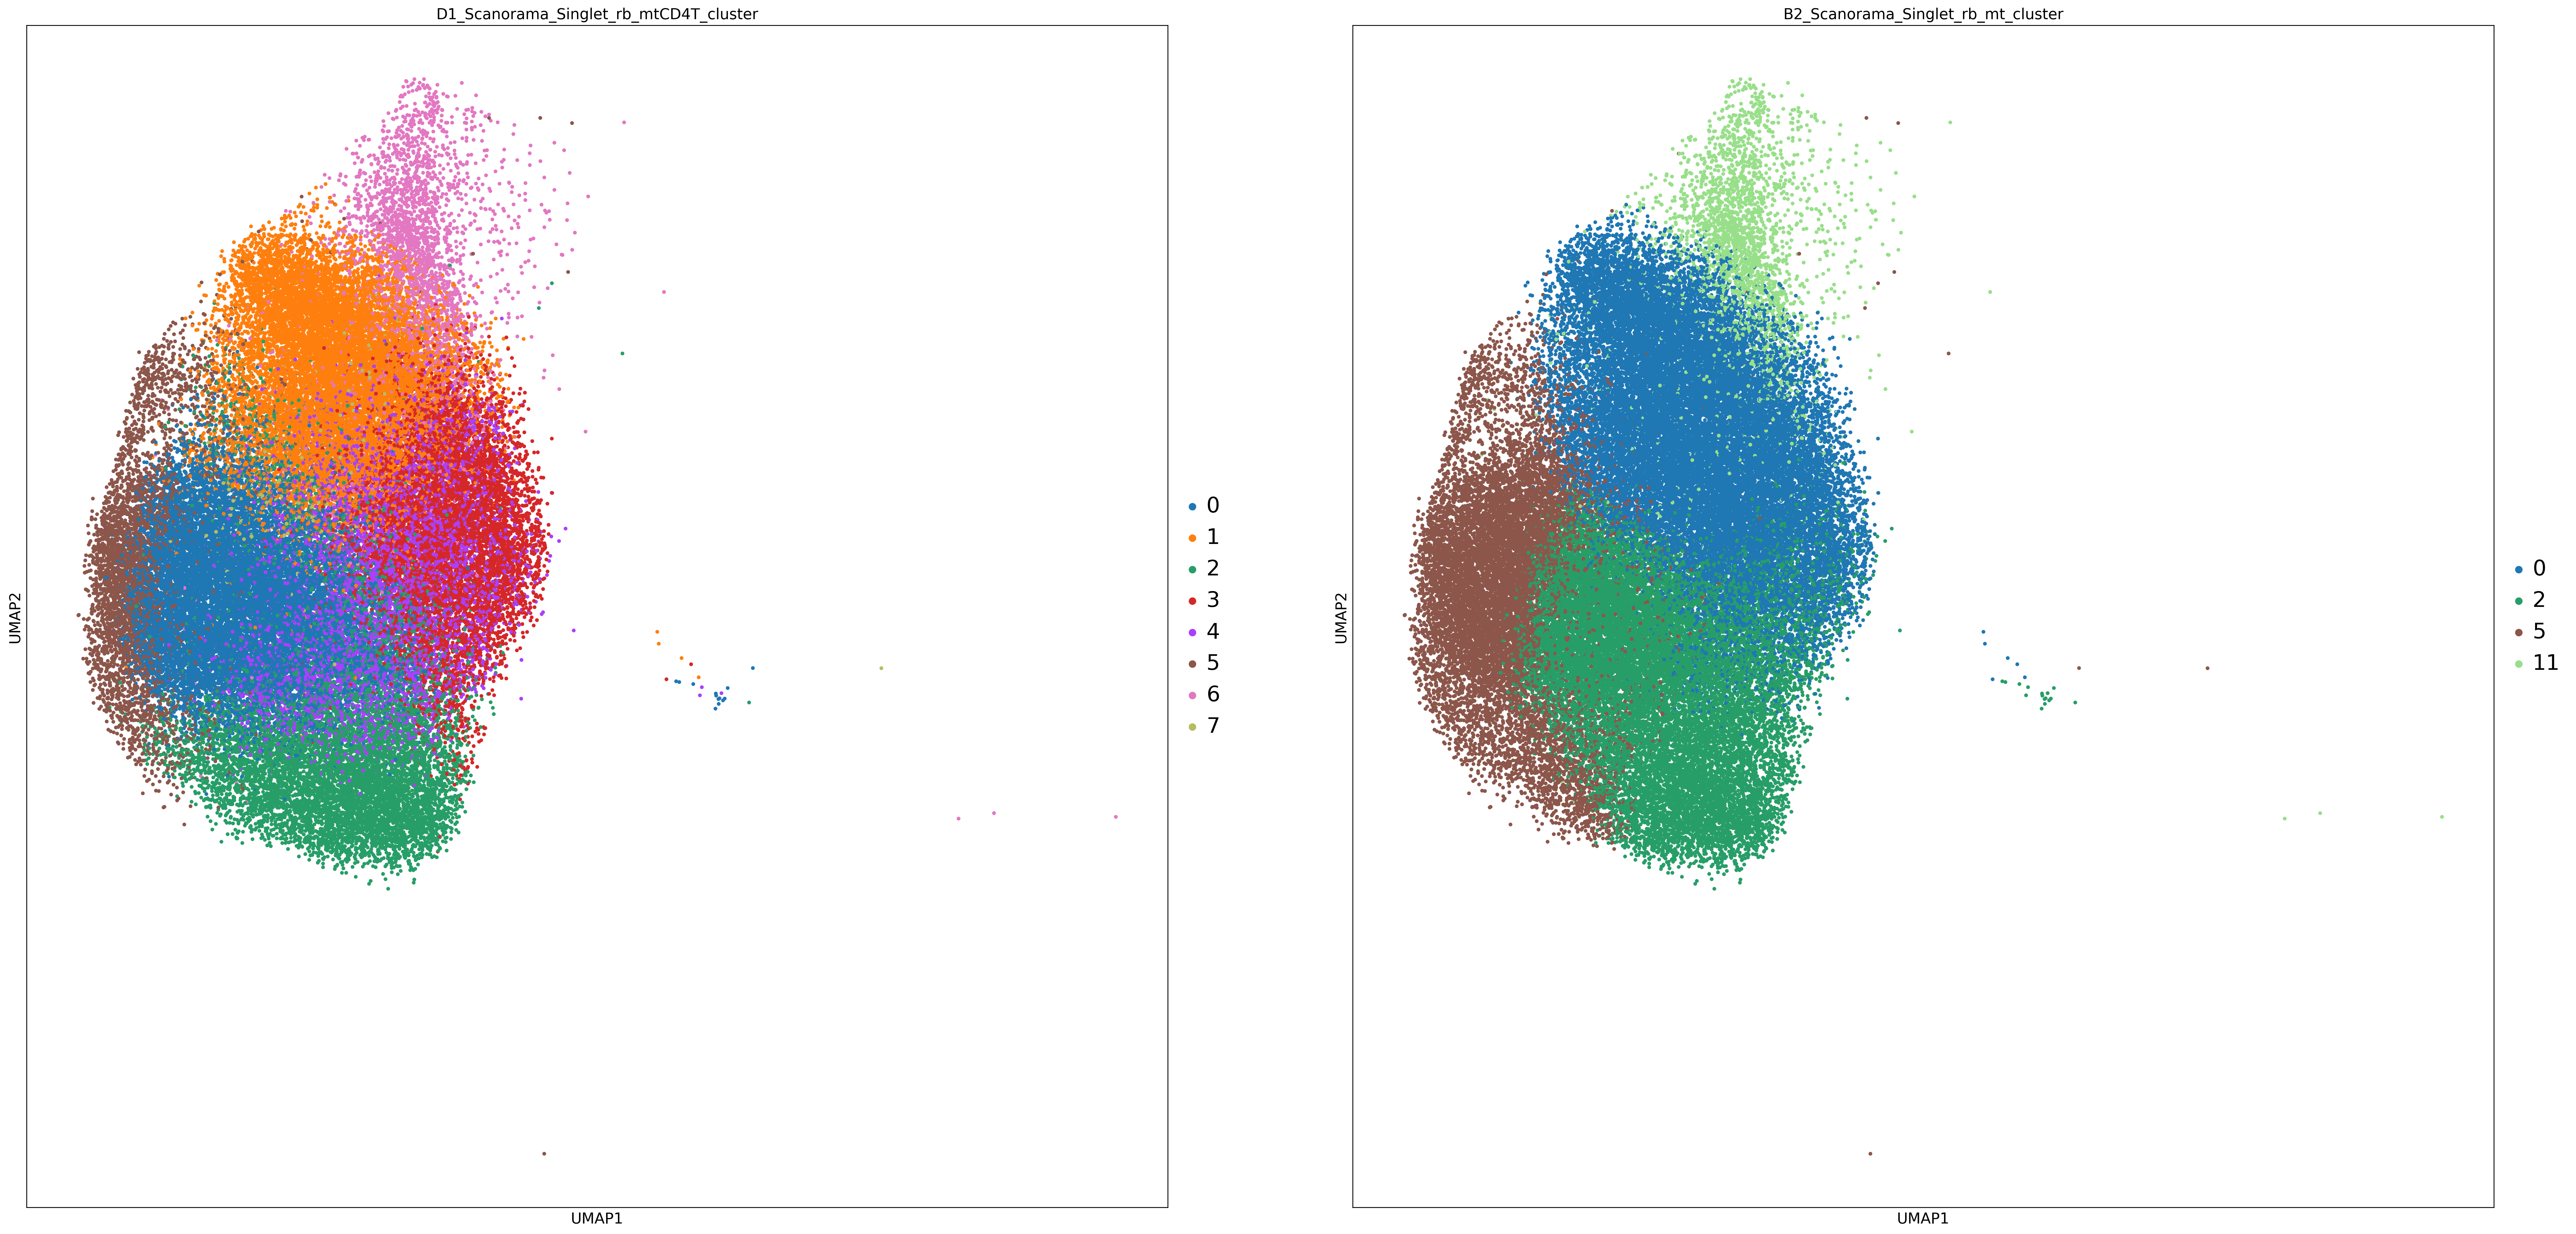

In [130]:
sc.set_figure_params(dpi=150, color_map = 'viridis_r', vector_friendly = False)
plt.rcParams['figure.figsize'] = [20, 20] 
for key in anndata_result:
    print('Library: ' + key)
    
    for umap in used_umap_list:
        used_umap = used_umap_list[umap]
        used_neighbors_key = used_neighbors_key_list[umap]
        print(used_umap)
        anndata_result[key].obsm['X_umap'] = anndata_result[key].obsm[used_umap]
        
        sc.pl.umap(anndata_result[key], color=['D1_Scanorama_Singlet_rb_mt' + cell_type +'_cluster', 'B2_Scanorama_Singlet_rb_mt_cluster' ], s = 50, ncols = 2, neighbors_key = used_neighbors_key, legend_fontsize = 'x-large', save = save_plot)
        #sc.pl.umap(anndata_dict[key], color=['ALL_PCA_50_10_neighbors_cluster','ALL_PCA_100_10_neighbors_cluster','library_id', 'group', 'HTO_classification_final', 'total_counts', 'HTO_classification.global',  'A5_scrublet_doublet_score_lib_0.2', 'A5_scrublet_predicted_doublet_lib0.2'], s = 10, ncols = 2, neighbors_key = used_neighbors_key)
    
    print('')
    ### Interesting parameters
    # use_raw = true - what to use for coloring with gene expression; default true if layer is not provided
    # layer = name of layer that should be plotted
    # neighbors_key = where to look for neighbors connectivities
    
    print ('')